## In this notebook we compare the PINNs solution to the Finite Difference solution

Date: 2 March 2023
@author Sayantan Auddy

We perform the following case studies:

Case1 : Sound wave propagation

Case2 : Jeans Instability for a fixed wavelength 

In [1]:
### For Google Colab #### 

# #mount the drive if running from Colab
# from google.colab import drive
# drive.mount('/content/drive')
# !pip install deepxde

In [2]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import deepxde as dde
import numpy as np
import os

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Concatenate, Flatten, Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization, Lambda
import matplotlib.pyplot as plt
import scipy
# plt.style.use('ggplot')
## Setting the backend to Tensorflow
dde_backend = tf

## For the FFT solver

from numpy.fft import fft, ifft
from scipy import signal

np.random.seed(1234)
tf.random.set_seed(1234)

Using backend: tensorflow.compat.v1

2023-03-10 19:05:41.242825: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 19:05:44.705071: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-10 19:05:50.345773: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-10 19:05:50.349667: W tensorflow/compiler/xla/stream_executo

Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.




### 1.1 Equations

The hydrostatic system with self-gravity-- 

For an isothermal gas, the dynamics is governed by continuity eqution and momentum equation. They are given as follows,

The mass-continuity equation
$$
\begin{equation}\label{continuity}
    \frac{\partial \rho}{\partial t} + \nabla.(\rho \vec v) =0
\end{equation}\tag{1}
$$
The momentum equation 
$$
\begin{eqnarray}\label{momentum}
\rho \frac{d \vec v}{ d t} = - \nabla P + \rho \vec g \\
\rho \left[\frac{\partial v}{\partial t}+ (\vec v . \nabla)\vec v \right] = - \nabla P + \rho \vec g
\end{eqnarray}\tag{3}
$$
The self-gravity is 
$$
\begin{equation}
\nabla. \vec g = -4\pi G\rho
\end{equation}\tag{3}
$$

where
$$
\begin{equation}\label{poisson}
\nabla^2 \phi =  4 \pi G \rho
\end{equation}\tag{4}
$$
is Poisson's equation and  

$$
\begin{equation}
\nabla \phi =  - \vec g 
\end{equation}\tag{5}
$$

For simplicity, we consider only 1-D. Later in the paper, we will implement 2D using PINNS.
$$
\begin{eqnarray}
    \frac{\partial \rho_1}{\partial t} + \rho_0 \frac{\partial v_1} {\partial x}  = 0 \\
    \rho_0 \frac{\partial v_1}{\partial t} = - c_s^{2} \frac{\partial \rho_1}{\partial x}  + \rho g_{1} \\
    % P_{1} = \gamma \frac{P_{0}}{\rho_0} \rho_1\\
    \frac{\partial g_1}{\partial x} = - 4 \pi G \rho_1
\end{eqnarray}\tag{6}
$$

#### The initial conditions is derivered using linear analysis (refer to the paper)

$$
\begin{eqnarray}
\rho(x,t=0) &=& \rho_{0} + \rho_{1}\cos\left(2\pi x/\lambda\right)
\end{eqnarray}\tag{7}
$$

When self-gravity is active and $\lambda> \lambda_{J}$ 

$$
\begin{eqnarray}
v_{x}(x,t=0) &=& -v_{1} \sin\left(2\pi x/\lambda\right)
\end{eqnarray}\tag{8}
$$

where $v_1 = \frac{\alpha}{k} \frac{\rho_1}{\rho}$ and 
$$
\begin{eqnarray}
    \alpha = \sqrt{ 4 \pi G \rho_0 - c_s^2 k^2}
\end{eqnarray}\tag{9}
$$
however for $\lambda < \lambda_{J}$  and for non self-gravitating system 

$$
\begin{eqnarray}
v_{x}(x) &=& v_{1} \cos\left(2\pi x/\lambda\right)
\end{eqnarray}\tag{10}
$$

#### Considering Periodic Boundary Conditions


$$
\begin{eqnarray}
\rho(x=0,t) &=& \rho (x=xmax,t)\\
v_{x}(x=t,t) &=& v_{x}(x
\end{eqnarray}\tag{11}
$$

<!-- $$
\begin{eqnarray}
=xmax,t)
\end{eqnarray}\tag{12}
$$ -->


### 1.2 Methodology : Using PINNs

The method constructs a neural network approximation. We consider a single neural network with the desired output varibles, $\rho$, $\vec v$ amd $\phi $ - 

$$
\begin{aligned}
\vec v_\theta(t,x), \rho_\theta(t,x), \phi_\theta(t,x) &\approx \mathcal N_{\rho, v}(X;\theta) \\
% \vec v_\theta(t,x) &\approx \mathcal N_{v}(X;\theta_{v})
\end{aligned}\tag{12}
$$

where $X:= (x,t)$, $\theta$ are the parameters for the networks. 

<!-- The idea is to first optimize the network parameters of $\mathcal N_{\rho}(X;\theta_{\rho})$ with those of $\mathcal N_{v}(X;\theta_{v})$ fixed and then vice versa, and the process is iterated until convergennce is achieved. -->

In this approach the total loss can be decoupled as:

The PDE losses associated with Eqs
$$
\begin{eqnarray}
\mathcal L_{\rho} =  \frac{1}{N_r}\sum_{i=1}^{N_r} \left|\partial_t \rho_{\theta}\left(t_i^r, x_i^r\right)+ \partial_x (\rho_{\theta}\left(t_i^r, x_i^r\right) \vec v_{\theta}\left(t_i^r, x_i^r\right)) \right|^2 
\end{eqnarray}\tag{13}
$$
<!-- $$
\begin{eqnarray}
\mathcal L_{\vec v} =  \frac{1}{N_r}\sum_{i=1}^{N_r}\left|\partial_t \left[\rho_{\theta} \left(t_i^r, x_i^r\right)\vec v_{\theta} \left(t_i^r, x_i^r\right)\right] + \partial_x \left[\rho_{\theta} \left(t_i^r, x_i^r\right)\vec v_{\theta} \left(t_i^r, x_i^r\right)\vec v_{\theta} \left(t_i^r, x_i^r\right)\right]+ c_s^2 \partial_x \rho_{\theta}\left(t_i^r, x_i^r\right)\right|^2
\end{eqnarray}\tag{14}
$$ -->
$$
\begin{eqnarray}
\mathcal L_{\vec v} = \frac{1}{N_r}\sum_{i=1}^{N_r} \left|\rho_{\theta} \left(t_i^r, x_i^r\right) \partial_t \vec v_{\theta} \left(t_i^r, x_i^r\right)+ \rho_{\theta} \left(t_i^r, x_i^r\right) \vec v_{\theta} \left(t_i^r, x_i^r\right) \partial_x \vec v_{\theta} \left(t_i^r, x_i^r\right) + c_s^2 \partial_x \rho_{\theta} \left(t_i^r, x_i^r\right) + \rho_{\theta} \left(t_i^r, x_i^r\right) \partial_x \phi  \right |^2
\end{eqnarray}\tag{14}
$$

$$
\begin{eqnarray}
\mathcal L_{\vec \phi} = \frac{1}{N_r}\sum_{i=1}^{N_r} \left| \partial_{xx}\phi\left(t_i^r, x_i^r\right) - const* \left(\rho_{\theta}\left(t_i^r, x_i^r\right) - \rho_o\right)   \right |^2
\end{eqnarray} 
$$

where $n$ is the total number of collocation points in the domain denoted by $X$ in a number of collocation points $X^r:=\{(t_i^r, x_i^r)\}_{i=1}^{N_r} $

The losses associated with initial and boundary conditions for density $\rho $


$$
    \begin{align*}
   \mathcal L_{\rho_0}(X^0) 
   := 
   \frac{1}{N_0}
   \sum_{i=1}^{N_0} \left|\rho_{\theta}\left(t_i^0, x_i^0\right) - \rho_{0}\left(x_i^0\right)\right|^2
   \quad \text{ and } \quad
   \mathcal L_{\rho_b}(X^b) 
   := 
   \frac{1}{N_b}
   \sum_{i=1}^{N_b} \left|\rho_{\theta}\left(t_i^b, x_i^b\right) - \rho_{b}\left(t_i^b, x_i^b\right)\right|^2
    \end{align*}\tag{15}
$$




The losses associated with initial and boundary conditions for velocity $\vec v_{\theta} $


$$
    \begin{align*}
   \mathcal L_{\vec v_0}(X^0) 
   := 
   \frac{1}{N_0}
   \sum_{i=1}^{N_0} \left|\vec v_{\theta}\left(t_i^0, x_i^0\right) - \vec v_{0}\left(x_i^0\right)\right|^2
   \quad \text{ and } \quad
   \mathcal L_{\vec  v_b}(X^b) 
   := 
   \frac{1}{N_b}
   \sum_{i=1}^{N_b} \left|\vec v\left(t_i^b, x_i^b\right) - \vec v_{b}\left(t_i^b, x_i^b\right)\right|^2
    \end{align*}\tag{16}
$$

<!-- in a number of points $X^0:=\{(t^0_i,x^0_i)\}_{i=1}^{N_0} \subset \{0\} \times \mathcal{D}$ and $X^b:=\{(t^b_i,x^b_i)\}_{i=1}^{N_b} \subset (0,T] \times \partial \mathcal{D}$, where $\vec v_\theta$ is the neural network approximation of the solution $\vec v\colon[0,T] \times \mathcal{D} \to \mathbb{R}$. -->

The losses associated with  boundary conditions for potential $\phi_{\theta} $

$$
   \begin{align*}   
   \mathcal L_{\phi_0}(X^b) 
   := 
   \frac{1}{N_b}
   \sum_{i=1}^{N_b}  \left|\phi_{\theta}\left(t_i^b, x_i^b\right) - \phi_{b}\left(t_i^b, x_i^b\right)\right|^2
    \end{align*}\tag{16}
$$

in a number of points $X^0:=\{(t^0_i,x^0_i)\}_{i=1}^{N_0} \subset \{0\} \times \mathcal{D}$ and $X^b:=\{(t^b_i,x^b_i)\}_{i=1}^{N_b} \subset (0,T] \times \partial \mathcal{D}$, where $\rho_\theta$ is the neural network approximation of the solution $\rho\colon[0,T] \times \mathcal{D} \to \mathbb{R}$.


In this sequential approach the total loss is decoupled as: 

$$
\begin{eqnarray}
\mathcal L_{\mathcal N_{\rho}} =  \mathcal L_{\rho} + \mathcal L_{\rho_0} +\mathcal L_{\rho_b} \\ 
\mathcal L_{\mathcal N{\vec v}} =  \mathcal L_{\vec v} + \mathcal L_{\vec v_0} +\mathcal L_{\vec v_b} 
\mathcal L_{\mathcal N_{\phi}} =   \mathcal L_{\phi_b} \\ 
\end{eqnarray}\tag{17}
$$

The TOTAL LOSS  

$$
\begin{eqnarray}
\mathcal L_{Total} = \mathcal L_{\rho} + \mathcal L_{\rho_0} +\mathcal L_{\rho_b}  +\mathcal L_{\vec v} + \mathcal L_{\vec v_0} +\mathcal L_{\vec v_b} + \mathcal L_{\vec \phi} + \mathcal L_{\phi_b} 
\end{eqnarray}
$$

In [3]:
#Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)
#%matplotlib inline

lam = 7.0           # one wavelength
num_of_wave = 5     # the number of waves
cs = 1.0            # % Sound Speed 
rho_1 = 0.01;       # question 2b non-linear wave propagation
rho_o = 1.0         # zeroth order density
const = 1 # 4.0 * np.pi           # The actual value is 4*pi
G = 1
alpha = np.sqrt(const*G*rho_o-cs**2*(2*np.pi/lam)**2)
# v_1 = (cs*rho_1)/rho_o # velocity perturbation without gravity
v_1  = (rho_1/rho_o) * (alpha/(2*np.pi/lam)) ## With gravity

tmax= 3
output_folder = "figures_" + str(lam) + '_' + str(tmax) + '_' + str(num_of_wave) +  '_' + str(rho_1)

try:
    os.makedirs(output_folder)
except OSError:
    print ("Creation of the directory %s failed/ not needed as it already exit" % output_folder)
else:
    print ("Successfully created the directory %s" % output_folder)
  

Creation of the directory figures_7.0_3_5_0.01 failed/ not needed as it already exit


### Network hyperparameters

In [4]:
## General Network Parameters

learning_rate = 1e-3
num_dense_layers = 3
num_dense_nodes = 30
activation = "sin" #"tanh"

iterations_adam = 2000

# collocation_points 
precision_train = 200 ## collocation points density
hx_train = lam/ precision_train
nx_train = int(1 / hx_train)*num_of_wave
print("The number of collocation points resolving the domain are = {} and at boundaries are = {}".format(nx_train*nx_train*tmax,50*nx_train))


The number of collocation points resolving the domain are = 58800 and at boundaries are = 7000


## Defining the PINNs 

Compiling model...
Building feed-forward neural network...
'build' took 0.141112 s



/home/sauddy3/PINNS-envcedar/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2023-03-10 19:06:04.708242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 19:06:09.062275: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-03-10 19:06:09.064776: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 24653 MB memor

wavelength 7.0
wavelength 7.0
'compile' took 5.953342 s

Initializing variables...


2023-03-10 19:06:10.556660: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled


Training model...



2023-03-10 19:06:11.463199: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x2ae4b000e040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-10 19:06:11.463318: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-03-10 19:06:11.932738: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-10 19:06:13.054348: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-10 19:06:15.204128: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                                                          Test loss                                                                           Test metric
0         [1.13e-01, 1.07e-01, 1.42e+00, 6.54e-01, 1.29e-01, 2.50e+00, 1.44e+00, 5.18e-01]    [1.13e-01, 1.07e-01, 1.42e+00, 6.54e-01, 1.29e-01, 2.50e+00, 1.44e+00, 5.18e-01]    []  
1000      [2.89e-04, 2.91e-04, 2.26e-04, 3.66e-05, 2.65e-06, 9.85e-06, 1.57e-04, 7.11e-05]    [2.89e-04, 2.91e-04, 2.26e-04, 3.66e-05, 2.65e-06, 9.85e-06, 1.57e-04, 7.11e-05]    []  
2000      [1.02e-04, 9.64e-05, 7.22e-05, 1.30e-05, 4.77e-07, 6.05e-06, 2.76e-05, 1.71e-05]    [1.02e-04, 9.64e-05, 7.22e-05, 1.30e-05, 4.77e-07, 6.05e-06, 2.76e-05, 1.71e-05]    []  

Best model at step 2000:
  train loss: 3.35e-04
  test loss: 3.35e-04
  test metric: []

'train' took 20.200553 s

Compiling model...
wavelength 7.0
wavelength 7.0
'compile' took 1.056618 s



2023-03-10 19:06:31.971038: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1780] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
2000      [1.02e-04, 9.64e-05, 7.22e-05, 1.30e-05, 4.77e-07, 6.05e-06, 2.76e-05, 1.71e-05]    [1.02e-04, 9.64e-05, 7.22e-05, 1.30e-05, 4.77e-07, 6.05e-06, 2.76e-05, 1.71e-05]    []  
3000      [7.99e-07, 1.07e-06, 1.54e-06, 2.57e-08, 9.02e-09, 8.61e-09, 1.87e-07, 5.31e-07]    [7.99e-07, 1.07e-06, 1.54e-06, 2.57e-08, 9.02e-09, 8.61e-09, 1.87e-07, 5.31e-07]        
4000      [3.15e-07, 6.76e-07, 9.96e-07, 4.83e-09, 1.23e-08, 1.10e-08, 8.22e-08, 1.30e-07]    [3.15e-07, 6.76e-07, 9.96e-07, 4.83e-09, 1.23e-08, 1.10e-08, 8.22e-08, 1.30e-07]        
5000      [3.09e-07, 3.64e-07, 5.48e-07, 1.16e-09, 5.66e-10, 9.23e-09, 6.87e-08, 8.04e-08]    [3.09e-07, 3.64e-07, 5.48e-07, 1.16e-09, 5.66e-10, 9.23e-09, 6.87e-08, 8.04e-08]        
6000      [2.26e-07, 2.77e-07, 3.56e-07, 2.58e-09, 2.69e-09

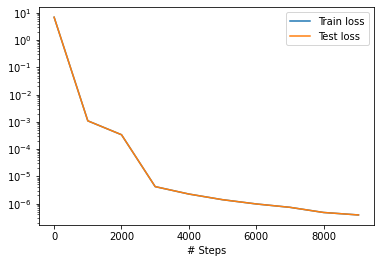

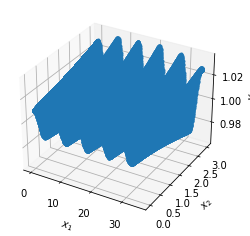

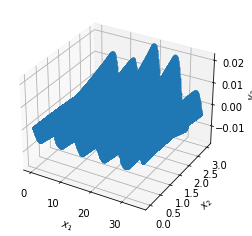

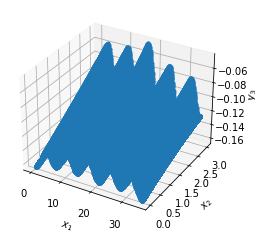

In [5]:
def pdeg(x, y):   

    '''
    The first argument to pde is a 2-dimensional vector where the first component(x[:,0]) is 𝑥
    -coordinate and the second componenet (x[:,1]) is the 𝑡-coordinate.

    The second argument is the network output,is 3-dimensional vector where the first component
    (y[:,0]) is density and the second componenet (y[:,1]) is the velocity amd the third component  (y[:,2])is 
    the gravity in the x direction
    '''
    cs = 1. ## Is the sound speed

    rho, v, phi = y[:,0:1],y[:,1:2],y[:,2:3]
    
    rho_t = dde.grad.jacobian(y, x, i=0, j=1)
    rho_x = dde.grad.jacobian(y, x, i=0, j=0)


    v_t = dde.grad.jacobian(y, x, i=1, j=1)
    v_x = dde.grad.jacobian(y, x, i=1, j=0)

   
    phi_x = dde.grad.jacobian(y, x, i=2, j=0)
    phi_xx= dde.grad.hessian(y, x, component=2, i=0, j=0)
    

    rho_r = rho_t + v * rho_x + rho * v_x ## The residue from the density equation
    # v_r = rho_t*v +rho*v_t + rho_x*v*v + rho*v_x*v + rho*v*v_x  +  cs*cs*rho_x +rho*phi_x  ## The residue from the momentum equation
    v_r = rho*v_t + rho*v*v_x + cs*cs*rho_x +rho*phi_x  ### THe momentum equation in 1D-
    
    # g_r = g_x + 4*np.pi*rho 
    phi_r = phi_xx - const*(rho - rho_o) ## The residue from the poisson equation
    
    # lam = 0.5
    # phi_r = phi_xx - (rho_1 * tf.cos(2*np.pi*x[:, 0:1]/lam- 2*np.pi*c_s*x[:, 1:2]/lam))
    
    return [rho_r, v_r ,phi_r]

xmin= 0 
xmax= lam*num_of_wave


geom = dde.geometry.Interval(xmin, xmax)
timedomain = dde.geometry.TimeDomain(0, tmax)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


def func(x):
    return 0

def boundary(x, on_boundary):
    return on_boundary

## Boundaries

## Note in the deep XDE code by default for the periodic boundary u(0) = u(1)
## If the problem is periodic this condition will also satisfy u(-1) = u(1)
## Thus is most cases the left boundary is not needed. But we have the option here

def boundary_l(x, on_boundary):  # boundary x=-1
    
    if xmin == -1:
        is_on_boundary_left = on_boundary and np.isclose(x[0], -1)
    else:
        is_on_boundary_left = on_boundary and np.isclose(x[0], 0)
    return is_on_boundary_left

def boundary_r(x, on_boundary):  # boundary x=1
    is_on_boundary_right = on_boundary and np.isclose(x[0], xmax)

    return is_on_boundary_right

## Boundary Conditions
bc_rho = dde.icbc.boundary_conditions.PeriodicBC(geomtime, 0, lambda _, on_boundary: on_boundary, component=0)
bc_v = dde.icbc.boundary_conditions.PeriodicBC(geomtime, 0, lambda _, on_boundary:on_boundary, component=1)
# bc_g = dde.icbc.boundary_conditions.DirichletBC(geom, lambda x: 0, lambda _, on_boundary: on_boundary, component=2)


bc_phir=dde.icbc.PeriodicBC(geomtime, 0, boundary_r,component =2) 


def fun_rho_0(x):
    ''' Define initial condition for density Returning Eq (11a)'''
    print('wavelength',lam)
    rho_0 = rho_o + rho_1 * tf.cos(2*np.pi*x[:, 0:1]/lam)    
    return rho_0
def fun_v_0(x):
    '''initial condition for velocity -- Returning Eq 11b'''
    # v_0 = v_1 * np.cos(2*np.pi*x[:, 0:1]/lam) ## This is for sound wave
    v_0 = - v_1 * np.sin(2*np.pi*x[:, 0:1]/lam) ## This is for the gravity wave
    return v_0

## Initial conditions.
ic_rho = dde.icbc.IC(geomtime,fun_rho_0, lambda _, on_initial: on_initial,component=0)

ic_v = dde.icbc.IC(geomtime,fun_v_0, lambda _, on_initial: on_initial,component=1 )


data = dde.data.TimePDE(geomtime,
                     pdeg,
                    #  [ic_rho,ic_v,bc_rho,bc_v],
                     [bc_rho,bc_v,bc_phir,ic_rho,ic_v],
                     num_domain=nx_train**2*tmax,   ## Working value 100000,30000,30000
                     num_boundary=50*nx_train,
                     num_initial=nx_train,
                    # num_test=10000,
                   )

net = dde.nn.FNN([2] + [num_dense_nodes] * num_dense_layers + [3], activation, "Glorot normal") ## working config 300*3
model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
model.train(iterations=iterations_adam)
model.compile("L-BFGS")

# # Optional: Save the model during training.
# checkpointer = dde.callbacks.ModelCheckpoint(
#     "model/model.ckpt", verbose=1, save_better_only=True
# )
# # Optional: Save the movie of the network solution during training.
# # ImageMagick (https://imagemagick.org/) is required to generate the movie.
# movie = dde.callbacks.MovieDumper(
#     "model/movie.movie", [-1], [1], period=100, save_spectrum=True, y_reference=func

# losshistory, train_state = model.train(iterations=10000, model_save_path = "model1")


losshistory, train_state = model.train(model_save_path = "./model1/saved_model")
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [6]:
def plot_function(time_array, velocity = False,isplot =False ,animation=False):
    
    if animation:
        ## Converting the float (time-input) to an numpy array for animation
        ## Ignore this when the function is called in isolation
        time_array = np.array([time_array])
        # print("time",np.asarray(time_array))
    
    rho_max_Pinns = []    
    peak_lst=[]
    pert_xscale=[]
    for t in time_array:
        print("Plotting at t=", t)
        X = np.linspace(xmin,xmax,1000).reshape(1000, 1)
        t_ = t*np.ones(1000).reshape(1000, 1)
        
        X_0 = np.hstack((X, t_))
        
        output_0 = model.predict(X_0)
        
        rho_pred0 = output_0[:,0:1]
        v_pred0 = output_0[:, 1:2]
        phi_pred0=output_0[:, 2:3]
        
        rho_max_PN = np.max(rho_pred0)
        ## Theoretical Values
        rho_theory = np.max(rho_o + rho_1*np.exp(alpha * t)*np.cos(2*np.pi*X[:, 0:1]/lam))
        
        ## Theoretical Values
        rho_theory = np.max(rho_o + rho_1*np.exp(alpha * t)*np.cos(2*np.pi*X[:, 0:1]/lam))
        rho_theory0 = np.max(rho_o + rho_1*np.exp(alpha * 0)*np.cos(2*np.pi*X[:, 0:1]/lam)) ## at t =0 
        
        diff=abs(rho_max_PN-rho_theory)/abs(rho_max_PN+rho_theory) * 2  ## since the den is rhomax+rhotheory

        
        ### Difference between peaks for the PINNs solution
        
        rho_pred0Flat=rho_pred0.reshape(-1)
        peaks,_=scipy.signal.find_peaks(rho_pred0Flat)
        peak_lst.append(peaks)
        
        growth_pert=(rho_theory-rho_theory0)/rho_theory0*100 ## growth percentage
        
        peak_diff=(rho_pred0Flat[peaks[1]]-rho_pred0Flat[peaks[0]])/(rho_pred0Flat[peaks[1]]+rho_pred0Flat[peaks[0]])

        #g_pred0=phi_x = dde.grad.jacobian(phi_pred0, X, i=0, j=0)
        if isplot:              
            print("rho_theory_max={} at time {}".format(rho_theory,t))
            plt.figure(1)
            plt.plot(X,rho_pred0,label="t={}".format(round(t,2)))
            plt.ylabel(r"$\rho$")
            plt.xlabel("x")
            plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
            # plt.title("Pinns Solution for $\lambda = {}$".format(lam))
            plt.title(r"Pinns Solution for $\lambda$ = {} $\lambda_J$ ".format(round(lam/(2*np.pi),2)))
            plt.savefig(output_folder+'/PINNS_density'+str(lam)+'_'+str(num_of_wave)+'_'+str(tmax)+'.png', dpi=300)


            if velocity == True:
              plt.figure(2)
              plt.plot(X,v_pred0,'--',label="t={}".format(round(t,2)))
              plt.ylabel("$v$")
              plt.xlabel("x")
              plt.title("Pinns Solution Velocity")
              plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
              plt.savefig(output_folder+'/PINNS_velocity'+str(lam)+'_'+str(num_of_wave)+'_'+str(tmax)+'.png', dpi=300)


            plt.figure(3)
            plt.plot(X,phi_pred0,'--',label="t={}".format(round(t,2)))
            plt.ylabel(r"$\phi$")
            plt.xlabel("x")
            plt.title("Pinns Solution phi")
            plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
            plt.savefig(output_folder+'/phi'+str(lam)+'_'+str(num_of_wave)+'_'+str(tmax)+'.png', dpi=300)

            plt.figure(4)
            
            plt.scatter(t,rho_max_PN)
            plt.plot(t,rho_theory,marker='^',label="LT")
            plt.legend(numpoints=1,loc='upper left',fancybox=True,shadow=True)
    #         plt.axhline(rho_theory , color = 'r', linestyle = '--')
            plt.xlabel("t")
            plt.ylabel(r"$\rho_{\rm max}$")
            plt.savefig(output_folder+'/rho_max'+str(lam)+'_'+str(num_of_wave)+'_'+str(tmax)+'.png', dpi=300)
            
            
            plt.figure(6)
            plt.scatter(growth_pert,peak_diff*100)
            plt.ylabel("peak difference $\%$")
            plt.xlabel("growth $\%$")
            #plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
            # plt.savefig('lambda7_peak_diff_growth.png')
            # plt.grid(True)
            plt.title('DIF bet 1st and central peak')
            plt.savefig(output_folder+'/gwt2'+str(lam)+'_'+str(num_of_wave)+'_'+str(tmax)+'.png', dpi=300)
            
            plt.figure(7)
            plt.scatter(growth_pert,diff*100)
            plt.ylabel("rel DIF-FD-PINN $\%$")
            plt.xlabel("growth $\%$")
            #plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
            # plt.savefig('lambda7_peak_diff_growth.png')
            # plt.grid(True)
            plt.title('relative DIF-FD-PINN')
            plt.savefig(output_folder+'/gwt1'+str(lam)+'_'+str(num_of_wave)+'_'+str(tmax)+'.png', dpi=300)
        
        else:  
            if animation:
                return X ,rho_pred0,v_pred0,phi_pred0,rho_max_PN,rho_theory
            else:
                return X ,rho_pred0,rho_max_PN,rho_theory 


#         plt.show()




Plotting at t= 0.0
rho_theory_max=1.01 at time 0.0
Plotting at t= 0.6
rho_theory_max=1.0130276522023514 at time 0.6
Plotting at t= 1.2
rho_theory_max=1.0169719721905428 at time 1.2
Plotting at t= 1.7999999999999998
rho_theory_max=1.022110495088637 at time 1.7999999999999998
Plotting at t= 2.4
rho_theory_max=1.028804784003656 at time 2.4
Plotting at t= 3.0
rho_theory_max=1.0375258707763484 at time 3.0


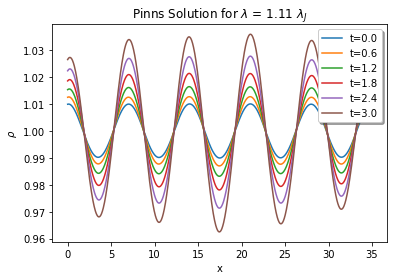

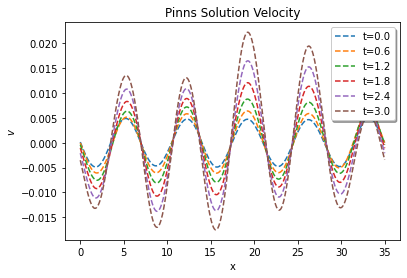

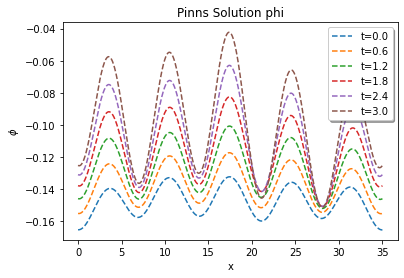

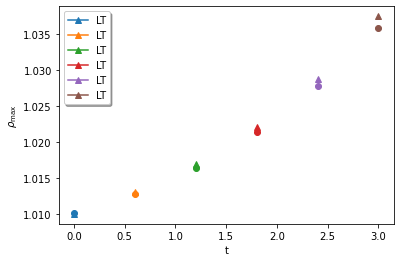

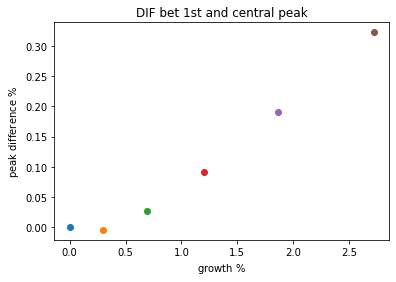

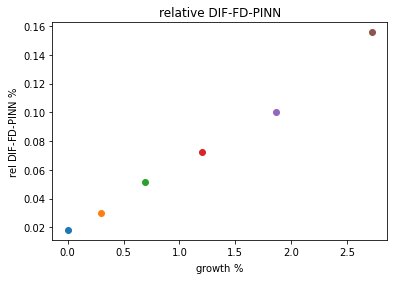

In [7]:
# import hydro_function as PF
# time_array = [0.0,1,2,3,4,5,6,7,8] 
time_array = np.linspace(0,tmax,tmax+3)
# time_array = np.linspace(0,1,4)
plot_function(time_array,velocity=True,isplot =True)


## To Animate the PINNs Solution

In [8]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib as mpl
# import matplotlib.animation as anim
# # from IPython.display import HTML
# from pathlib import Path

# from matplotlib import animation, rc
# # from IPython.display import HTML, Image # For GIF

# # rc('animation', html='html5')

# from matplotlib.animation import FuncAnimation
# # import matplotlib.animation as animation

# # plt.style.use('ggplot')

# ## Time and Space Array
# t = np.linspace(0,tmax,100)
# # X = np.linspace(xmin,xmax,N).reshape(N, 1)
# # numDataPoints = len(t)
# # X_0 = np.hstack((X, t_))

# # # Initialize plot

# fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2)
# fig.set_size_inches(8,8)
# # ax1.set_xlim([-1, 1])

# def animate_func(num):
#     ax1.clear()  # Clears the figure to update the line, point,   
#     ax2.clear()  
#     ax3.clear()  # Clears the figure to update the line, point
#     # ax4.clear()  # Clears the figure to update the line, point
    
#     # t_ = t[num+1]*np.ones(1000).reshape(1000, 1)
#     t0 = t[0]*np.ones(1000).reshape(1000, 1)

    
#     X ,rho_pred0,v_pred0,phi_pred0,rho_max,rho_theory =  plot_function(t[num],velocity=True,isplot = False, animation=True)
#     X_intial = np.hstack((X,t0))
#     intial_output = model.predict(X_intial)
    
#     lim_y_b = rho_o - rho_1*10 ## To fix the axes ylim auto
#     lim_y_u = rho_o + rho_1*10
    
#     ax1.plot(X, rho_pred0, "-", color = "C3", lw = 2,label="t={}".format(round(t[num+1],3)))
#     ax1.plot(X, intial_output[:,0:1], "--", color = "C3", lw = 2,label=" t= 0")
#     ax1.set_ylabel(r"$\rho$")
#     ax1.set_ylim([lim_y_b,lim_y_u ])
#     ax1.set_xlabel("x")
    
#     # rho,v ,n = lax_solution_animate(t[num+1],N,rho_1 = rho_1,velocity=False)
#     # ax1.plot(X,rho[n-1,:],linewidth=1,label="lax-Sol")
#     ax1.legend(numpoints=1,loc='lower right',fancybox=True,shadow=True)



#     ax3.plot(X,v_pred0,label=" t={}".format(round(t[num+1],3)))
#     ax3.set_ylabel("$v$")
#     ax3.set_ylim([-0.5,0.5 ])
#     ax3.set_xlabel("x")
    
#     # ax2.plot(X,v[n-1,:],linewidth=1,label="lax-Sol")
#     ax3.legend(numpoints=1,loc='lower right',fancybox=True,shadow=True)
    
#     ax2.plot(X,phi_pred0,'--',label="PINNS at t={}".format(round(t[num+1],3)))
#     ax2.set_ylabel("$\phi$")
#     ax2.set_xlabel("x")
#     ax2.set_ylim([-1.3,.6])
    
#     rho_max = np.max(rho_pred0)
#         # print(rho_max)
#     ax4.scatter(t[num],rho_max,c = 'red')
#     ax4.set_ylim([1,lim_y_u])
#     ax4.set_xlim([0,tmax+0.5])
#     ax4.set_xlabel("t")
#     ax4.set_ylabel(r"$\rho_{\rm max}$")
#     plt.title(r"Pinns Solution for $\lambda$ = {} $\lambda_J$ ".format(round(lam/(2*np.pi),2)))
#     plt.tight_layout()



# line_ani = FuncAnimation(fig, animate_func, interval=30,   
#                                    frames=numDataPoints-1)
  
# ### saving to m4 using ffmpeg writer
# # writervideo = animation.FFMpegWriter(fps=20)
# # line_ani.save('instability_'+str(lam)+ '.mp4', writer=writervideo)
# ax4.clear()  # Clears the figure to update the line, point
# line_ani.save(output_folder+'/instability_'+str(lam)+ '.gif', writer='pillow', fps=60)
# plt.close()
# plt.show()
# print("[INFO]: Animation is complete")

In [9]:
rho_o + rho_1*10

1.1

### 1.3 LAX Method

Here the Lax method is used to integrate the flux conservative form of the continuity and momentum equations. For an equation of the form 

$$
\begin{equation}
\frac{\partial f}{\partial t} = -\frac{\partial }{\partial x}\left(fv\right)
\end{equation}\tag{1}
$$

the Lax method is the finite-difference approximation,

$$
\begin{equation}
\frac{f^{n+1}_{j}-\left( f^{n}_{j+1} + f^{n}_{j-1}\right)/2}{\Delta t}=-\frac{f^{n}_{j+1}v^{n}_{j+1}-f^{n}_{j-1}v^{n}_{j-1}}{2\Delta x}
\end{equation}\tag{2}
$$
Forward Time Centered Space (FTCS) method is unconditionally unstable . But the Lax method is conditionally stable if,

$$
\begin{equation}
\nu \equiv \frac{c\Delta t}{\Delta x} \leq 1
\end{equation}\tag{3}
$$

Where $\nu$ is known as Courant number. Physically it means that the signal cannot travel more than $\Delta x$ in $\Delta t$ time.
$$
\begin{eqnarray}
\rho\frac{\partial v_{x}}{\partial t}+\rho v_{x}\frac{\partial v_{x}}{\partial x} &=& -c^{2}_{s}\frac{\partial\rho}{\partial x} + \rho \vec{g} \nonumber\\
\Rightarrow \rho\frac{\partial v_{x}}{\partial t} +\frac{\partial\rho v_{x} v_{x}}{\partial x} - v_{x}\frac{\partial\rho v_{x}}{\partial x} &=& -c^{2}_{s}\frac{\partial\rho}{\partial x} + \rho \vec{g} \nonumber\\
\Rightarrow \rho\frac{\partial v_{x}}{\partial t} - v_{x}\frac{\partial \rho v_{x}}{\partial x} &=&-\frac{\partial \rho v_{x} v_{x}}{\partial x}-c^{2}_{s}\frac{\partial\rho}{\partial x} + \rho \vec{g}
\end{eqnarray}\tag{8}
$$

Now substituting equation (4a) in to  (7c) we get,
$$
\begin{eqnarray}
\rho\frac{\partial v_{x}}{\partial t} +v_{x}\frac{\partial \rho}{\partial t} &=& -\frac{\partial\rho v_{x} v_{x}}{\partial x}-c^{2}_{s}\frac{\partial\rho}{\partial x} + \rho \vec{g}\nonumber\\
\Rightarrow \frac{\partial\rho v_{x}}{\partial t} &=&-\frac{\partial\rho v_{x} v_{x}}{\partial x}-c^{2}_{s}\frac{\partial\rho}{\partial x}+ \rho \vec{g}\nonumber
\end{eqnarray}\tag{9}
$$

Hence the flux conservative form of momentum equation and the continuity equation is given by,

$$
\begin{eqnarray}
\frac{\partial \rho}{\partial t} &=& -\frac{\partial}{\partial x}\left(\rho v_{x}\right)\\
\end{eqnarray}\tag{10}
$$
$$
\begin{eqnarray}
\frac{\partial\left(\rho v_{x}\right)}{\partial t} &=&-\frac{\partial}{\partial x}\left(\rho v_{x} v_{x}\right)-c^{2}_{s}\frac{\partial\rho}{\partial x} + \rho \vec{g}
\end{eqnarray}\tag{11}
$$

Equation (10) and (11) will decide the dynamics of gas with given boundary and initial condition.


$$
\begin{eqnarray}
\rho(x) &=& \rho_{0} + \rho_{1}\cos\left(2\pi x/\lambda\right)\\
v_{x}(x) &=& v_{1} \cos\left(2\pi x/\lambda\right) or \\
\end{eqnarray}\tag{11}
$$

If $\omega^2 < 0$, the system in unstable such that $4 \pi G \rho_0 > c_s^2 k^2$. The $\omega = \pm i \alpha$ where 

$$
\begin{eqnarray}
    \alpha = \sqrt{ 4 \pi G \rho_0 - c_s^2 k^2}
\end{eqnarray}
$$

Then the initial velocity perturbation is
$$
\begin{eqnarray}
v_{x}(x) &=& - v_{1} \sin\left(2\pi x/\lambda\right)
\end{eqnarray}
$$

where
$$
\begin{eqnarray}
     i \omega \rho_1 - i  k \rho_0 v_1 =& 0  \\ \nonumber
     v_1 =& \frac{\omega}{k}\frac{\rho_1}{\rho_0} 
\end{eqnarray}
$$

In this section using the Lax method equation (9) and (10) are solved. If the equation (2) is subsituted in  (9) and (10) we will get the following as the solution for $\rho$ and $v_{x}$.

$$
\begin{eqnarray}
\rho^{n+1}_{j}= \frac{1}{2}\left(\rho^{n}_{j+1} +\rho^{n}_{j-1}\right)-\frac{\Delta t}{2\Delta x}\left(\rho^{n}_{j+1} v^{n}_{j+1}-\rho^{n}_{j-1} v^{n}_{j-1}\right)\\
U^{n+1}_{j} = \frac{1}{2}\left(U^{n}_{j+1} +U^{n}_{j-1}\right)-\frac{\Delta t}{2\Delta x}\left(U^{n}_{j+1} v^{n}_{j+1}-U^{n}_{j-1} v^{n}_{j-1}\right)-\frac{c^{2}_{s}\Delta t}{2\Delta x}\left(\rho^{n}_{j+1}-\rho^{n}_{j-1}\right) -\frac{\Delta t \rho^n_{j}}{2\Delta x}\left(\phi^{n}_{j+1}-\phi^{n}_{j-1}\right)
\end{eqnarray}
$$

$$
\begin{equation}
U^{n}_{j} = v^{n}_{j} \rho^{n}_{j}
\end{equation}
$$


In [10]:
def fft_solver(rho,Lx,N, dim = None):
    
    '''
    A FFT solver that uses discrete Fast Fourier Transform to
    solve the poisson Equation:
    We apply the correct due to the finite difference grid of phi
    
    Input: 1. The source function density in this case
           2. # of grid point N
           3. Domain Size in each dimension
    
    Output: the potential phi and the field g 
    
    '''
    nx = N
    Lx = Lx
    
    dx = Lx / nx
    
    
    # Calculate the Fourier modes of the gas density
    rhohat = fft(rho)

    # Calculate the wave numbers in x and y directions
    kx = 2 * np.pi * np.fft.fftfreq(nx, dx)
    #ky = 2 * np.pi * np.fft.fftfreq(ny, dy)

    # Construct the Laplacian operator in Fourier space
    kx2 = np.meshgrid(kx**2)
    
#     laplace = -(kx**2 )
    ## Laplace with the correction refer to the notes
    laplace = 2*(np.cos(kx*dx)-1)
    
    ## Inorder to avoid the inf we replace zero with a small number
    laplace[laplace == 0] = 1e-16
    
    # Solve for the gravitationa potential in Fourier space
    phihat = rhohat / laplace
    
    phihat = rhohat * dx**2/laplace
#     window = signal.windows.tukey(len(phihat),alpha=0.25)


    # Transform back to real space to obtain the solution
#     phi = np.real(ifft(phihat*window))
    phi = np.real(ifft(phihat))
    
    ## The field ,i.e., gravity 
    dphidx = np.gradient(phi, dx)

    return phi,dphidx

In [11]:

######### Finite Difference Solution #######
# rho_1 = 0.03
# rho_o = 1            # zeroth order density


def lax_solution(time,lam,num_of_waves,rho_1 = rho_1,gravity=False,isplot = None,animation=None):
    # rho_max = []
    lam = lam          # one wavelength
    num_of_waves  = num_of_waves  
    L = lam * num_of_waves            # Maximum length (two wavelength)
    
    print("at time= ",time)
    ### Declaring the Constants

    c_s = 1.0            # % Sound Speed        
    nu = 0.5            # courant number (\nu = 2 in 2d)
    rho_1 = rho_1        # question 2a linear wave propagation
    const =  1 # 4.0 * np.pi           # The actual value is 4*pi
    G = 1

    ### Grid X-T 
    N = 1000            # The grid resolution values2d:N =(10,50,100,500)
    dx = float(L/N)      # length spacing        
    dt = nu*2*dx         # time grid spacing

    n = int(time/dt)     # grid points in time
    print("For time grid n = {} ".format(n))
    
    ## Initializing the ARRAY
    x = np.linspace(0, L, N)
    rho = np.zeros((n,N))
    dphidx = np.zeros((n,N))
    phi = np.zeros((n,N))
    v =np.zeros((n,N))  
    P =np.zeros((n,N))
    
#         print(np.shape(rho))

    jeans = np.sqrt(4*np.pi**2*c_s**2/(const*G*rho_o))
    print("Jean's Length",jeans)

    
    ######################## Initial Conditions ###########################
    rho[0,:] = rho_o + rho_1* np.cos(2*np.pi*x/lam) # defing the density at t = 0
    
    if gravity == False:
        print("Propagation of Sound wave")
        v_1 = (c_s*rho_1)/rho_o # velocity perturbation
        v[0,:] = v_1 * np.cos(2*np.pi*x/lam) # the velocity at t =0
    else:
        if lam >= jeans:
            print("There is gravitational instabilty  lam = {} > l_jean ={}".format(lam,jeans))
            alpha = np.sqrt(const*G*rho_o-c_s**2*(2*np.pi/lam)**2)
            v_1  = (rho_1/rho_o) * (alpha/(2*np.pi/lam)) ## With gravity        
            v[0,:] = - v_1 * np.sin(2*np.pi*x/lam) # the velocity at t =0
            ## density values from Linear Theory at t
            rho_LT = rho_o + rho_1*np.exp(alpha * time)*np.cos(2*np.pi*x/lam)
            rho_LT_max = np.max(rho_o + rho_1*np.exp(alpha * time)*np.cos(2*np.pi*x/lam))
#             print("rho_theory_max={} and the max density {} at time {}".format(rho_LT_max ,rho_max, round(time,2)))

        else:
            print("There is no gravitational instabilty as lam = {} < l_jean ={}".format(lam,jeans))
            alpha = np.sqrt(c_s**2*(2*np.pi/lam)**2 - const*G*rho_o)
            v_1 = (rho_1/rho_o) * (alpha/(2*np.pi/lam)) # velocity perturbation
            v[0,:] = v_1 * np.cos(2*np.pi*x/lam) # the velocity at t =0

        ## Calculating the potential and the field using FFT    
        phi[0,:],dphidx[0,:] = fft_solver(const*(rho[0,:]-rho_o),L,N, dim = None)

    ######### The Flux term #########
    P=rho*v

    #################################FINITE DIFFERENCE #######################
    for k in range(1,n):

        rho[k,:] = 0.5*(np.roll(rho[k-1,:],-1)+ np.roll(rho[k-1,:],1))-(nu*(np.roll(rho[k-1,:],-1)*np.roll(v[k-1,:],-1)-np.roll(rho[k-1,:],1)*np.roll(v[k-1,:],1)))

        if gravity == False:

            P[k,:] = 0.5*(np.roll(P[k-1,:],-1)+ np.roll(P[k-1,:],1))-(nu*(np.roll(P[k-1,:],-1)*np.roll(v[k-1,:],-1)- np.roll(P[k-1,:],1)*np.roll(v[k-1,:],1)))-((c_s**2)*nu*(np.roll(rho[k-1,:],-1)- np.roll(rho[k-1,:],1)))
        else:

            P[k,:] = 0.5*(np.roll(P[k-1,:],-1)+ np.roll(P[k-1,:],1))-(nu*(np.roll(P[k-1,:],-1)*np.roll(v[k-1,:],-1)- np.roll(P[k-1,:],1)*np.roll(v[k-1,:],1)))\
            -((c_s**2)*nu*(np.roll(rho[k-1,:],-1)- np.roll(rho[k-1,:],1))) -(nu*rho[k-1,:]*(np.roll(phi[k-1,:],-1)- np.roll(phi[k-1,:],1)))#  - dt*rho[k-1,:]* dphidx[k-1,:]  #  # np.roll(rho[k-1,:],-1)*np.roll(dphidx[k-1,:],-1)

            phi[k,:],dphidx[k,:] = fft_solver(const*(rho[k,:]-rho_o),L,N, dim = None) ## Please note we don't use dphidx rather calculate using central differencing

    

        v[k,:] = P[k,:]/rho[k,:]
    rho_max = np.max(rho)   
    ################################# PLOTTING #######################
 
    if isplot : 
        plt.figure(1,figsize=(6,4))
        plt.plot(x,rho[n-1,:]-rho_o,linewidth=1,label="t={}".format(round(time,2)))
        plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
        plt.xlabel(r"$\mathbf{x}$")
        # plt.text(.6,.15,r"dt=%f"%(dt),fontsize=12)
        plt.title("At time {} and rho_1 = {}".format(time,rho_1))
        plt.ylabel(r"$\mathbf{\rho - \rho_{0}}$")

        plt.figure(2,figsize=(6,4))
        plt.plot(x,v[n-1,:],'--',markersize=2,label="t={}".format(round(time,2)))
        plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
        plt.xlabel(r"$\mathbf{x}$")
        plt.title(r"Lax Solution Velocity For $\rho_1$ = {}".format(rho_1))
        plt.ylabel("velocity")

        if gravity:
             #### Plotting the comparison of the \rho_max for FD and Linear Theory 
            
            plt.figure(3,figsize=(6,4))                                
            plt.scatter(time,rho_max)
            plt.scatter(time,rho_LT_max,facecolors='none', edgecolors='r',label="LT")           
            plt.xlabel("t")
            plt.ylabel(r"$\log (\rho_{\rm max} - \rho_{0}) $")
            plt.yscale('log')
            plt.legend(numpoints=1,loc='upper left',fancybox=True,shadow=True)

            ## Plotting the gravitational potential (\phi) and field (g)
            plt.figure(4,figsize=(6,4))
            plt.plot(x,phi[n-1,:],'--',markersize=2,label="t=phi at {}".format(round(time,2)))
#                 plt.plot(x,dphidx[n-1,:],'--',markersize=2,label="g at t={}".format(time))
            plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
            plt.xlabel(r"$\mathbf{x}$")
            plt.title(r"Lax Solution Phi For $\rho_1$ = {}".format(rho_1))
            plt.ylabel(r"$\Phi$")

            plt.figure(5,figsize=(6,4))
#                 plt.plot(x,phi[n-1,:],'--',markersize=2,label="t=phi at {}".format(time))
            plt.plot(x,dphidx[n-1,:],'--',markersize=2,label="g at t={}".format(round(time,2)))
            plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
            plt.xlabel(r"$\mathbf{x}$")
            plt.title(r"Lax Solution Phi For $\rho_1$ = {}".format(rho_1))
            plt.ylabel(r"$g$")

    else:
        if gravity:
            return x,rho,v,phi,dphidx,n,rho_LT,rho_LT_max,rho_max
        else:
            return rho,v
            
    ## Clearing the memory
    del rho, dphidx, phi, v, P

at time=  1.0
For time grid n = 28 
Jean's Length 6.283185307179586
There is gravitational instabilty  lam = 7.0 > l_jean =6.283185307179586
at time=  1.6666666666666665
For time grid n = 47 
Jean's Length 6.283185307179586
There is gravitational instabilty  lam = 7.0 > l_jean =6.283185307179586
at time=  2.333333333333333
For time grid n = 66 
Jean's Length 6.283185307179586
There is gravitational instabilty  lam = 7.0 > l_jean =6.283185307179586
at time=  3.0
For time grid n = 85 
Jean's Length 6.283185307179586
There is gravitational instabilty  lam = 7.0 > l_jean =6.283185307179586


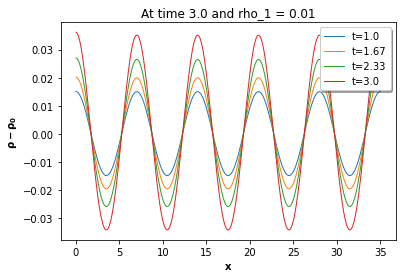

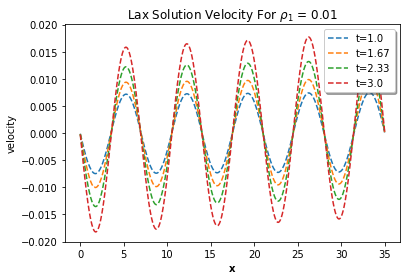

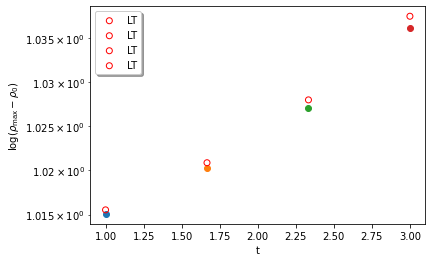

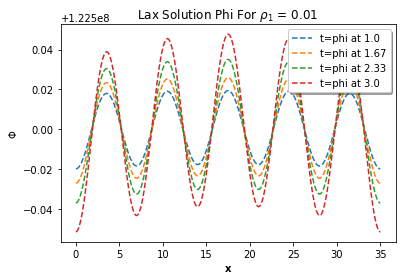

In [ ]:
# lam = 7
# num_of_waves  = 3
# tmax = 3
# time = tmax

## Plotting the results from the lax solution for any given time
# lax_solution(time,lam,num_of_waves,rho_1,gravity=True,isplot=True)

## For overplotting the results for differnt times:
time_array = np.linspace(1,tmax,tmax+1)
for time in time_array:
    lax_solution(time,lam,num_of_wave,rho_1,gravity=True,isplot=True)

In [ ]:
## Comparison of the results from the PINNS and Finite-Difference Methods
## The idea is to plot the over density as a function to X from PINNs and FD methods 
## four different time instances 


time_array = np.linspace(0.05,tmax,4)

Growth_LT_list = []
Growth_FD_list = []
Growth_PN_list = []
# plt.style.use('ggplot')     
fig, axes = plt.subplots(2, 2, figsize=(10, 8),sharex=True, sharey=True)
fig.suptitle(r"PINNS vs FD for $\lambda$ = {} $\lambda_J$ ".format(round(lam/(2*np.pi),2)))
plt.subplots_adjust(hspace = 0.4)
axes = axes.ravel()
# for k, ax in enumerate(axes):
for time, ax in zip(time_array,axes):
    x,rho,v,phi,dphidx,n, rho_LT,rho_LT_max,rho_max_FD= lax_solution(time,lam,num_of_wave, rho_1,gravity=True,isplot=False,animation =True)
    X ,rho_pred0,v_pred0,phi_pred0,rho_max_PN,rho_theory = plot_function(time,velocity=True,isplot = False, animation=True)
    ax.plot(x,rho[n-1,:],linewidth=2,label="FD")
    ax.plot(X,rho_pred0,'k',label="PN")
    ax.plot(x,rho_LT,'--',linewidth=2,label="LT")
    ax.set_title("t={}".format(round(time,2)))
    ax.set_ylabel(r"$\rho$")
    ax.set_xlabel("x")
    ax.grid("True")
    
    # ax.legend()
   
    Growth_LT = rho_LT_max - rho_o
    Growth_FD = rho_max_FD - rho_o  
    Growth_PN = rho_max_PN - rho_o
    Growth_LT_list.append(Growth_LT)
    Growth_FD_list.append(Growth_FD)
    Growth_PN_list.append(Growth_PN)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5)
plt.savefig(output_folder+'/PINN-FD-Comp'+str(lam)+'_'+str(num_of_wave)+'_'+str(tmax)+'.png', dpi=300)


# print(Growth_FD_list)
plt.figure(2)
plt.plot(time_array,Growth_LT_list,marker='o', color='b',label= "LT")
plt.plot(time_array, Growth_FD_list,'--',marker='o',color='r',label= "FD")
plt.plot(time_array, Growth_PN_list,marker='o',markersize=4,color = 'r',label="PN") 
plt.xlabel("t")
plt.ylabel(r"$\log (\rho_{\rm max} - \rho_{0}) $")
plt.yscale('log')
plt.savefig(output_folder+'/log-PINN-FD-Comp'+str(lam)+'_'+str(num_of_wave)+'_'+str(tmax)+'.png', dpi=300)
# plt.grid("True")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.figure(3)
diff_FD = (np.array(Growth_LT_list) - np.array(Growth_FD_list))
diff_PN = (np.array(Growth_LT_list) - np.array(Growth_PN_list))
# diff_FD = (np.array(Growth_LT_list) - np.array(Growth_PN_list))
plt.plot(time_array,np.array(diff_FD),label="FD")
plt.plot(time_array,np.abs(diff_PN),label="PN")
plt.ylabel(r"residue |$\rho_{max}$ -  $\rho_{max LT}|$")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig(output_folder+'/DIFF-PINN-FD-Comp'+str(lam)+'_'+str(num_of_wave)+'_'+str(tmax)+'.png', dpi=300)
# plt.yscale('log')

In [ ]:
time_array = np.linspace(0.05,tmax,8)
rho_max_PN = []
rho_TH = []
rho_FD = []
Growth_LT_list = []
Growth_FD_list = []
Growth_PN_list = []
# plt.figure(figsize=(5, 5))
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(10, 8),sharex=True, sharey=False)
plt.subplots_adjust(wspace = 0.3)
fig.suptitle(r"PINNS vs FD for $\lambda$ = {} $\lambda_J$ ".format(round(lam/(2*np.pi),2)))
for time in time_array:
    x,rho,v,phi,dphidx,n, rho_LT,rho_LT_max,rho_max= lax_solution(time,lam,num_of_wave, rho_1,gravity=True,isplot=False,animation =True)
    X ,rho_pred0,v_pred0,phi_pred0,rho_max_Pinns,rho_theory  = plot_function(time,velocity=True,isplot = False, animation=True)

    rho_max_PN.append(rho_max_Pinns)
    rho_TH.append(rho_LT_max)
    rho_FD.append(rho_max)
    

    Growth_LT = rho_LT_max - rho_o
    Growth_FD = rho_max - rho_o 
    Growth_PN = rho_max_Pinns - rho_o
    Growth_LT_list.append(Growth_LT)
    Growth_FD_list.append(Growth_FD)
    Growth_PN_list.append(Growth_PN)
    
ax1.plot(time_array,Growth_LT_list,marker='2',markersize=4,color = 'b',label="LT")
ax1.plot(time_array, Growth_FD_list,'--',marker='3',markersize=4,color = 'k',label="FD")   
ax1.plot(time_array, Growth_PN_list,marker='o',markersize=4,color = 'r',label="PN") 
ax1.grid("True")
ax1.set_ylabel(r"$\log (\rho_{\rm max} - \rho_{0}) $")
ax1.set_yscale('log')
ax1.legend()

ax2.plot(time_array,rho_max_PN,marker='o',markersize=4,color = 'r',label="PN")
ax2.plot(time_array,rho_TH,marker='2',markersize=4,color = 'b',label="LT")
ax2.plot(time_array,rho_FD,'--',marker='3',markersize=4,color = 'k',label="FD")
ax2.set_ylabel(r"$\rho_{max}$")
ax2.grid("True")
# ax2.set_title(r"$\rho_m$ growth comparison for $\lambda$ = {} $\lambda_J$ ".format(round(lam/(2*np.pi),2)),fontsize=10)



diff_FD = (np.array(Growth_LT_list) - np.array(Growth_FD_list))
diff_PN = (np.array(Growth_LT_list) - np.array(Growth_PN_list))
# diff_FD = (np.array(Growth_LT_list) - np.array(Growth_PN_list))
ax3.plot(time_array,np.abs(diff_FD),label="FD")
ax3.plot(time_array,np.abs(diff_PN),label="PN")
ax3.set_ylabel(r"residue |$\rho_{max}$ -  $\rho_{max LT}|$")
ax3.set_yscale('log')
ax3.legend()
ax3.set_xlabel("Time")
ax3.grid("True")
ax4.set_xlabel("Time")

plt.savefig(output_folder+'/comp_rho_max'+str(lam)+'_'+str(num_of_wave)+'_'+str(tmax)+'.png')
# ax.scatter(t,rho_max)
# ax.plot(t,rho_theory,marker='^',label="LT")

## To Animate and compare the solutions

In [ ]:
# t = np.linspace(0,tmax,100)
# fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2)
# fig.set_size_inches(8,8)
# # ax1.set_xlim([-1, 1])
# numDataPoints = len(t-1)
# def animate_func(num):
#     ax1.clear()  # Clears the figure to update the line, point,   
#     # ax2.clear()  
#     ax3.clear()  # Clears the figure to update the line, point
#     # ax4.clear()  # Clears the figure to update the line, point
    
#     # t_ = t[num+1]*np.ones(1000).reshape(1000, 1)
#     t0 = t[0]*np.ones(1000).reshape(1000, 1)

#     x,rho,v,phi,dphidx,n,rho_LT,rho_LT_max,rho_max= lax_solution(t[num+1],lam,num_of_wave, rho_1,gravity=True,isplot=False,animation =True)
#     X ,rho_pred0,v_pred0,phi_pred0,rho_max_Pinns,rho_theory =  plot_function(t[num+1],velocity=True,isplot = False, animation=True)
#     X_intial = np.hstack((X,t0))
#     intial_output = model.predict(X_intial)
    
       
#     lim_y_b = rho_o - rho_1*5 ## To fix the axes ylim auto
#     lim_y_u = rho_o + rho_1*5
    
#     ax1.plot(X, rho_pred0, "-", color = "red", lw = 4,label="PN at t={}".format(round(t[num+1],3)))
#     ax1.plot(X, intial_output[:,0:1], "--", color = "C3", lw = 2,label=" t= 0")
#     ax1.plot(x,rho[n-1,:],linewidth=2,color = "black",label="FD")
#     ax1.plot(x,rho_LT,'--',linewidth=2,color = "blue",label="LT")
#     ax1.set_ylabel(r"$\rho$")
#     ax1.set_ylim([lim_y_b,lim_y_u ])
#     ax1.set_xlabel("x")
#     ax1.legend(numpoints=1,loc='lower right',fancybox=True,shadow=True)
#     # rho,v ,n = lax_solution_animate(t[num+1],N,rho_1 = rho_1,velocity=False)
#     # ax1.plot(X,rho[n-1,:],linewidth=1,label="lax-Sol")
    
    
#     ax2.scatter(t[num],np.log(rho_max-rho_o),c = 'black',s=20,label="FD")
#     ax2.scatter(t[num],np.log(rho_max_Pinns-rho_o),c = 'red',s=5,label="PN")
#     ax2.scatter(t[num],np.log(rho_LT_max-rho_o),c = 'blue',s=2,label="LT")
#     # ax2.set_ylim([0,0.1])

#     # # ax2.grid("True")
#     ax2.set_ylabel(r"$\log (\rho_{\rm max} - \rho_{0}) $")
#     # ax2.set_yscale('log')
#     ax2.set_ylim([-3.5,-2])
#     ax2.set_xlim([0,tmax+0.5])
#     # ax2.legend()

#     ax3.plot(X,v_pred0,color = "red",label=" PN at t=={}".format(round(t[num+1],3)))
#     ax3.plot(x,v[n-1,:],color = "black",label="FD")
#     ax3.set_ylabel("$v$")
#     ax3.set_ylim([-0.3,0.3 ])
#     ax3.set_xlabel("x")    
#     ax3.legend(numpoints=1,loc='lower right',fancybox=True,shadow=True)
    
    
    
# #     ax2.plot(X,phi_pred0,'--',label="PINNS at t={}".format(round(t[num+1],3)))
# #     ax2.plot(x,phi[n-1,:],color = "black",label="FD")
# #     ax2.set_ylabel("$\phi$")
# #     ax2.set_xlabel("x")
# #     ax2.set_ylim([-1.3,.6])
    
#     # rho_max = np.max(rho_pred0)
#     ax4.scatter(t[num],rho_max,c = 'black',s=20,label="FD")
#     ax4.scatter(t[num],rho_max_Pinns,c = 'red',s=5,label="PN")
#     ax4.scatter(t[num],rho_LT_max,c = 'blue',s=2,label="LT")
#     # ax4.legend(numpoints=1,loc='lower right',fancybox=True,shadow=True)
    
#     ax4.set_ylim([1,lim_y_u])
#     ax4.set_xlim([0,tmax+0.5])
#     ax4.set_xlabel("t")
#     ax4.set_ylabel(r"$\rho_{\rm max}$")
#     plt.title(r"Pinns Solution for $\lambda$ = {} $\lambda_J$ ".format(round(lam/(2*np.pi),2)))
#     plt.tight_layout()



# line_ani = FuncAnimation(fig, animate_func, interval=30,   
#                                    frames=numDataPoints-1)
  
# ### saving to m4 using ffmpeg writer
# # writervideo = animation.FFMpegWriter(fps=20)
# # line_ani.save('instability_comp'+str(lam)+ '.mp4', writer=writervideo)
# ax2.clear()  
# ax4.clear()  # Clears the figure to update the line, point
# line_ani.save(output_folder+'/'instability_comp'+str(lam)+ '.gif', writer='pillow', fps=60)
# plt.close()
# plt.show()
# print("[INFO]: Animation is complete")

In [ ]:
np.log(rho_max-rho_o)